## PFT level variables
uses sparse grid example from ESDS
https://ncar.github.io/esds/posts/2022/sparse-PFT-gridding/


#### Import Libraries

In [2]:
%matplotlib inline

import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sparse
import xarray as xr

# some nice plotting settings
xr.set_options(cmap_sequential=mpl.cm.YlGn, keep_attrs=True)
plt.rcParams["figure.dpi"] = 120
cbar_kwargs = {"orientation": "horizontal", "shrink": 0.8, "aspect": 30}


def setup_axes():
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    return ax

#### Read in dataset

In [3]:
pft_constants = xr.open_dataset(
    "/glade/p/cesm/cseg/inputdata/lnd/clm2/paramdata/clm5_params.c190529.nc"
)
pftnames = pft_constants.pftname
HIST = 'TOTVEGC'
data = xr.open_dataset(
    "/glade/campaign/cgd/cesm/CESM2-LE/lnd/proc/tseries/month_1/"+HIST+ \
    "/b.e21.BHISTcmip6.f09_g17.LE2-1301.006.clm2.h1."+HIST+".200001-200912.nc",
    decode_times=True,
    chunks={"time": 100},
)
data2 = xr.open_dataset(
    "/glade/campaign/cgd/cesm/CESM2-LE/lnd/proc/tseries/month_1/"+HIST+ \
    "/b.e21.BSSP370cmip6.f09_g17.LE2-1301.006.clm2.h1."+HIST+".204501-205412.nc",
    decode_times=True,
    chunks={"time": 100},
)

data

<xarray.Dataset>
Dimensions:             (levgrnd: 25, levlak: 10, levdcmp: 25, lon: 288,
                         lat: 192, gridcell: 21013, landunit: 62125,
                         column: 554298, pft: 848480, time: 120,
                         hist_interval: 2)
Coordinates:
  * levgrnd             (levgrnd) float32 0.01 0.04 0.09 ... 19.48 28.87 42.0
  * levlak              (levlak) float32 0.05 0.6 2.1 4.6 ... 25.6 34.33 44.78
  * levdcmp             (levdcmp) float32 0.01 0.04 0.09 ... 19.48 28.87 42.0
  * lon                 (lon) float32 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
  * lat                 (lat) float32 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * time                (time) object 2000-02-01 00:00:00 ... 2010-01-01 00:0...
Dimensions without coordinates: gridcell, landunit, column, pft, hist_interval
Data variables: (12/45)
    area                (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    landfrac            (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
    landmask            (lat, lon) float64 dask.array<chunksize=(192, 288), meta=np.ndarray>
    pftmask             (lat, lon) float64 dask.array<chunksize=(192, 288), meta=np.ndarray>
    nbedrock            (lat, lon) float64 dask.array<chunksize=(192, 288), meta=np.ndarray>
    grid1d_lon          (gridcell) float64 dask.array<chunksize=(21013,), meta=np.ndarray>
    ...                  ...
    mscur               (time) float64 dask.array<chunksize=(100,), meta=np.ndarray>
    nstep               (time) float64 dask.array<chunksize=(100,), meta=np.ndarray>
    time_bounds         (time, hist_interval) object dask.array<chunksize=(100, 2), meta=np.ndarray>
    date_written        (time) object dask.array<chunksize=(100,), meta=np.ndarray>
    time_written        (time) object dask.array<chunksize=(100,), meta=np.ndarray>
    TOTVEGC             (time, pft) float32 dask.array<chunksize=(100, 848480), meta=np.ndarray>
Attributes: (12/102)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 07/08/20 10:27:40
    source:                                    Community Land Model CLM4.0
    hostname:                                  aleph
    ...                                        ...
    cft_irrigated_tropical_corn:               62
    cft_tropical_soybean:                      63
    cft_irrigated_tropical_soybean:            64
    time_period_freq:                          month_1
    Time_constant_3Dvars_filename:             ./b.e21.BHISTcmip6.f09_g17.LE2...
    Time_constant_3Dvars:                      ZSOI:DZSOI:WATSAT:SUCSAT:BSW:H...

In [4]:
burn = xr.open_dataset(
    "/glade/campaign/cgd/cesm/CESM2-LE/lnd/proc/tseries/month_1/FAREA_BURNED/b.e21.BHISTcmip6.f09_g17.LE2-1301.006.clm2.h0.FAREA_BURNED.200001-200912.nc",
    decode_times=True,
    chunks={"time": 100},
)
burn2 = xr.open_dataset(
    "/glade/campaign/cgd/cesm/CESM2-LE/lnd/proc/tseries/month_1/FAREA_BURNED/b.e21.BSSP370cmip6.f09_g17.LE2-1301.006.clm2.h0.FAREA_BURNED.204501-205412.nc",
    decode_times=True,
    chunks={"time": 100},
)

Our goal here is to expand this 2D GPP dataarray to a 4D sparse array `(time, type, lat, lon)`.

This way no extra memory is used to represent NaNs over the ocean.

We get to work with a substantially simpler representation of the dataset.

We develop the following two functions: to_sparse and convert_pft_variables_to_sparse

In [5]:
def to_sparse(data, vegtype, jxy, ixy, shape):
    """
    Takes an input numpy array and converts it to a sparse array.

    Parameters
    ----------
    data: numpy.ndarray
        1D or 2D Data stored in compressed form.
    vegtype: numpy.ndarray

    jxy: numpy.ndarray
        Latitude index
    ixy: numpy.ndarray
        Longitude index
    shape: tuple
        Shape provided as sizes of (vegtype, jxy, ixy) in uncompressed
        form.

    Returns
    -------
    sparse.COO
        Sparse nD array
    """
    import sparse

    # This constructs a list of coordinate locations at which data exists
    # it works for arbitrary number of dimensions but assumes that the last dimension
    # is the "stacked" dimension i.e. "pft"
    if data.ndim == 1:
        coords = np.stack([vegtype, jxy - 1, ixy - 1], axis=0)
    elif data.ndim == 2:
        # generate some repeated time indexes
        # [0 0 0 ... 1 1 1... ]
        itime = np.repeat(np.arange(data.shape[0]), data.shape[1])
        # expand vegtype and friends for all time instants
        # by sequentially concatenating each array for each time instants
        tostack = [np.concatenate([array] * data.shape[0]) for array in [vegtype, jxy - 1, ixy - 1]]
        coords = np.stack([itime] + tostack, axis=0)
    else:
        raise NotImplementedError

    return sparse.COO(
        coords=coords,
        data=data.ravel(),
        shape=data.shape[:-1] + shape,
        fill_value=np.nan,
    )


def convert_pft_variables_to_sparse(dataset, pftnames):
    """
    Convert 2D PFT variables in dataset to 4D sparse arrays.

    Parameters
    ----------
    dataset: xarray.Dataset
        Dataset with DataArrays that have a `pft` dimension.

    Returns
    -------
    xarray.Dataset
        Dataset whose "PFT" arrays are now sparse arrays
        with `pft` dimension expanded out to (type, lat, lon)
    """

    import sparse
    import xarray as xr

    # extract PFT variables
    pfts = xr.Dataset({k: v for k, v in dataset.items() if "pft" in v.dims})

    # extract coordinate index locations
    ixy = dataset.pfts1d_ixy.astype(int)
    jxy = dataset.pfts1d_jxy.astype(int)
    vegtype = dataset.pfts1d_itype_veg.astype(int)
    npft = len(pftnames.data)

    # expected shape of sparse arrays to pass to `to_sparse` (excludes time)
    output_sizes = {
        "vegtype": npft,
        "lat": dataset.sizes["lat"],
        "lon": dataset.sizes["lon"],
    }

    result = xr.Dataset()
    # we loop over variables so we can specify the appropriate dtype
    for var in pfts:
        result[var] = xr.apply_ufunc(
            to_sparse,
            pfts[var],
            vegtype,
            jxy,
            ixy,
            kwargs=dict(shape=tuple(output_sizes.values())),
            input_core_dims=[["pft"]] * 4,
            output_core_dims=[["vegtype", "lat", "lon"]],
            dask="parallelized",
            dask_gufunc_kwargs=dict(
                meta=sparse.COO(np.array([], dtype=pfts[var].dtype)),
                output_sizes=output_sizes,
            ),
            keep_attrs=True,
        )

    # copy over coordinate variables lat, lon
    result = result.update(dataset[["lat", "lon"]])
    result["vegtype"] = pftnames.data
    # save the dataset attributes
    result.attrs = dataset.attrs
    return result

#### Now convert to gridded output

In [6]:
sparse_data = convert_pft_variables_to_sparse(data, pftnames)
sparse_data2 = convert_pft_variables_to_sparse(data2, pftnames)
sparse_data[HIST]

<xarray.DataArray 'TOTVEGC' (time: 120, vegtype: 79, lat: 192, lon: 288)>
dask.array<transpose, shape=(120, 79, 192, 288), dtype=float32, chunksize=(100, 79, 192, 288), chunktype=sparse.COO>
Coordinates:
  * time     (time) object 2000-02-01 00:00:00 ... 2010-01-01 00:00:00
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * vegtype  (vegtype) |S40 b'not_vegetated                           ' ... b...
Attributes:
    long_name:     total vegetation carbon, excluding cpool
    units:         gC/m^2
    cell_methods:  time: mean

#### Quick sanity check of results

In [ ]:
ax = setup_axes()
sparse_data[HIST].isel(vegtype=1, time=6).plot(robust=True, ax=ax, cbar_kwargs=cbar_kwargs)


### select grid & take mean to get a quick climatology


In [6]:

Blat = 40
Blon =(360-105.3)
# dominant PFTs are 1,2,13
# Extra memory may be a good idea (> 4GB for this step)
BC = sparse_data.sel(lat=Blat, lon=Blon, method='nearest').mean('time').isel(vegtype=[1,2,13]).load()
BC2 = sparse_data2.sel(lat=Blat, lon=Blon, method='nearest').mean('time').isel(vegtype=[1,2,13]).load()
print('loaded data')

loaded data


In [10]:
if HIST=='GPP' or HIST=='NPP':
    cflux = True
else:
    cflux = False
#Convert units
if cflux == True:
    BC[HIST] = BC[HIST]*365*24*3600
    BC2[HIST] = BC2[HIST]*365*24*3600
    BC[HIST].attrs['units']= 'gC/m2/y'
    BC2[HIST].attrs['units']= 'gC/m2/y'

print(BC.vegtype)

<xarray.DataArray 'vegtype' (vegtype: 3)>
array([b'needleleaf_evergreen_temperate_tree     ',
       b'needleleaf_evergreen_boreal_tree        ',
       b'c3_non-arctic_grass                     '], dtype='|S40')
Coordinates:
    lon      float32 255.0
    lat      float32 40.05
  * vegtype  (vegtype) |S40 b'needleleaf_evergreen_temperate_tree     ' ... b...


<xarray.DataArray 'vegtype' (vegtype: 3)>
array([b'needleleaf_evergreen_temperate_tree     ',
       b'needleleaf_evergreen_boreal_tree        ',
       b'c3_non-arctic_grass                     '], dtype='|S40')
Coordinates:
    lon      float32 255.0
    lat      float32 40.05
  * vegtype  (vegtype) |S40 b'needleleaf_evergreen_temperate_tree     ' ... b...

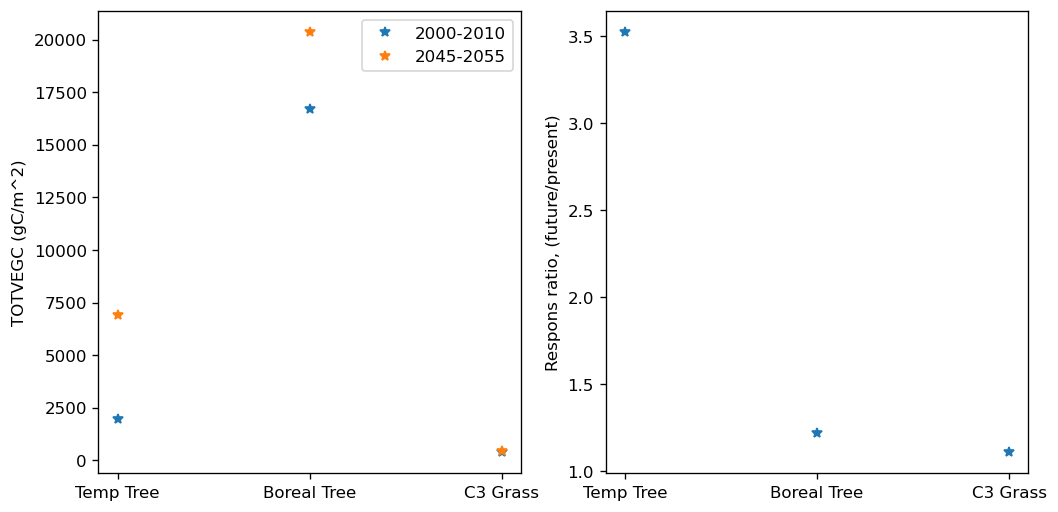

In [7]:
BC['Veg'] = ['Temp Tree','Boreal Tree','C3 Grass']
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.plot(BC.Veg,BC[HIST],'*',label="2000-2010")
plt.plot(BC.Veg,BC2[HIST],'*',label="2045-2055")
plt.ylabel(HIST+' ('+BC[HIST].attrs['units']+')')

plt.legend()
plt.subplot(122)
plt.plot(BC.Veg,BC2[HIST]/BC[HIST],'*')
plt.ylabel('Respons ratio, (future/present)')

#plt.plot(BC.Veg,BC.pfts1d_wtgcell,'*');
#plt.plot(BC.Veg,BC2.pfts1d_wtgcell,'*');
#plt.ylabel('Grid Weight');


BC.vegtype

In [119]:
BCburn = burn.sel(lat=Blat, lon=Blon, method='nearest').mean('time').load()
BCburn2 = burn2.sel(lat=Blat, lon=Blon, method='nearest').mean('time').load()

In [120]:
BCburn.FAREA_BURNED*(3600*24*365)

<xarray.DataArray 'FAREA_BURNED' ()>
array(0.00127804)
Coordinates:
    lon      float32 255.0
    lat      float32 40.05
Attributes:
    long_name:     timestep fractional area burned
    units:         s-1
    cell_methods:  time: mean

In [121]:
BCburn2.FAREA_BURNED*(3600*24*365)

<xarray.DataArray 'FAREA_BURNED' ()>
array(0.00059588)
Coordinates:
    lon      float32 255.0
    lat      float32 40.05
Attributes:
    long_name:     timestep fractional area burned
    units:         s-1
    cell_methods:  time: mean